In [1]:
import os
import numpy as np
import pickle
import torch
import torchvision as tv
import torch.nn.functional as F
import torch.nn as nn


from tqdm import tqdm
from matplotlib import pyplot as plt
from liger_kernel.diffusers.conv2d_transpose import LigerConv2dTranspose
from liger_kernel.diffusers.conv2d import LigerConv2d
from liger_kernel.diffusers.linear import LigerLinear
from liger_kernel.diffusers.mse import LigerMSE
from liger_kernel.diffusers.functional import LigerGELU, LigerReLU
import cv2

In [2]:
# Config model
T = 300 # Max diffusion step
max_seq_length = 5
vocab_size = 27 # ' ': 0, 'a':1, ..., 'z':26
hidden_dim = 256

device = "cuda:0"
# device = "cpu"
batch_size = 32

In [3]:
# Download dataset
mnist_data = tv.datasets.MNIST("./", download=True,
                               transform=tv.transforms.Compose([
                                  tv.transforms.ToTensor(), # first, convert image to PyTorch tensor
                              ]))

train_data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)

In [4]:
# Utilities
n2t_mapping = {
    0: 'zero',
    1: 'one',
    2: 'two',
    3: 'three',
    4: 'four',
    5: 'five',
    6: 'six',
    7: 'seven',
    8: 'eight',
    9: 'nine',
    10: 'ten'
}

string_to_token = lambda x: [ord(i) - 96 for i in x] # ' ': 0, 'a':1, ..., 'z':26
# token_to_string = lambda x: [chr(i + 96) for i in x] # We do not need it here

def convert_text_label(number_labels):
  text_labels = torch.zeros((len(number_labels), max_seq_length, vocab_size))
  for bidx, nlb in enumerate(number_labels):
    tokens = string_to_token(
              n2t_mapping[nlb]
            )
    for tidx, token in enumerate(tokens):
      text_labels[bidx, tidx, token] = 1.
  return text_labels

def show_img(img):
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.show()

In [ ]:
# Models for noise estimation
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()
        '''
        standard ResNet style convolutional block
        '''
        self.same_channels = in_channels==out_channels
        self.is_res = is_res
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.is_res:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            # this adds on correct residual in case channels have increased
            if self.same_channels:
                out = x + x2
            else:
                out = x1 + x2
            return out / 1.414
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        '''
        process and downscale the image feature maps
        '''
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*[ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)])

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        '''
        process and upscale the image feature maps
        '''
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        generic one layer FC NN for embedding things
        '''
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = nn.GRU(n_classes, 2*n_feat, batch_first=True)
        self.contextembed2 = nn.GRU(n_classes, 1*n_feat, batch_first=True)

        self.up0 = nn.Sequential(
            # nn.ConvTranspose2d(6 * n_feat, 2 * n_feat, 7, 7), # when concat temb and cemb end up w 6*n_feat
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7), # otherwise just have 2*n_feat
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        # x is (noisy) image, c is context label, t is timestep,
        # context_mask says which samples to block the context on

        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        # mask out context if context_mask == 1
        context_mask = (-1*(1-context_mask)) # need to flip 0 <-> 1
        c = c * context_mask

        # embed context, time step
        cemb1 = self.contextembed1(c)[0].view(-1, max_seq_length, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c)[0].view(-1, max_seq_length, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # could concatenate the context embedding here instead of adaGN
        # hiddenvec = torch.cat((hiddenvec, temb1, cemb1), 1)

        up1 = self.up0(hiddenvec)
        # up2 = self.up1(up1, down2) # if want to avoid add and multiply embeddings
        up2 = self.up1(cemb1.mean(1)*up1+ temb1, down2)  # add and multiply embeddings
        esp_theta_w_context = self.up2(cemb2.mean(1)*up2+ temb2, down1)

        esp_theta_wo_context = x + t[:, None, None, None]

        out = self.out(torch.cat((esp_theta_w_context, esp_theta_wo_context), 1))
        return out

In [6]:
# Noise learning - Epsilon_theta
esp_theta_model = ContextUnet(in_channels=1, n_feat=hidden_dim, n_classes=vocab_size).to(device)

# Optimizer and Loss
model_params = esp_theta_model.parameters()
optimizer = torch.optim.Adam(model_params, lr=1e-4)
loss_fn = torch.nn.MSELoss()
# loss_fn = LigerMSE()

In [7]:
# Load saved models
# !cp "/content/drive/MyDrive/Colab Notebooks/Diffusion/contextual_model.pt" contextual_model.pt
# !cp "/content/drive/MyDrive/Colab Notebooks/Diffusion/beta_t.pkl" beta_t.pkl

# esp_theta_model.load_state_dict(torch.load('contextual_model.pt'))
# beta_t = pickle.load(open('beta_t.pkl', 'rb')).to(device)

In [8]:
# Random beta
beta_1 = 1e-4
beta_2 = 2e-2
beta_t = (beta_2 - beta_1) * torch.arange(0, T+1, dtype=torch.float32) / T + beta_1
beta_t = beta_t.to(device)

In [9]:
# Calculate alphabar
alpha_t = 1 - beta_t
log_alpha_t = torch.log(alpha_t)
alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

sqrtab = torch.sqrt(alphabar_t)
sqrtmab = torch.sqrt(1 - alphabar_t)

sqrt_beta_t = torch.sqrt(beta_t)
oneover_sqrta = 1 / torch.sqrt(alpha_t)
mab_over_sqrtmab = (1 - alpha_t) / sqrtmab

In [10]:
# TRAINING
epochs = 1
for e in range(epochs):
  print('========== EPOCH %d ==========' % e)
  total_loss = 0
  batch_idx = 0

  for imgs, lbs in tqdm(train_data_loader):
    # Input preparation
    x_in = imgs.to(device) # batch, img_size, img_size
    context = convert_text_label(lbs.numpy().tolist()).to(device) # batch, max_length, onehot_size

    # Forward diffusion
    ## Posterior prob calculation
    t = torch.randint(low=1, high=T+1, size=(x_in.shape[0],)).to(device) # batch
    esp = torch.randn_like(x_in).to(device) # batch, img_size, img_size

    x_t = (
              sqrtab[t, None, None, None] * x_in
              + sqrtmab[t, None, None, None] * esp
          )

    ## Prior prob calculation
    context_mask = torch.bernoulli(torch.zeros_like(context) + 0.1).to(device)
    esp_theta = esp_theta_model(x_t, context, t / T, context_mask) # batch, img_size, img_size

    # Loss calculation
    loss = loss_fn(esp, esp_theta)
    total_loss += loss.cpu().item()
    if batch_idx % 100 == 0:
      print("\tLoss:", loss.item())

    # Optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Increase batch idx
    batch_idx += 1

========== EPOCH 0 ==========


  0%|          | 0/1875 [00:00<?, ?it/s]

	Loss: 1.088270902633667


  5%|▌         | 103/1875 [00:12<02:47, 10.59it/s]

	Loss: 0.07152137160301208


 11%|█         | 201/1875 [00:21<02:38, 10.56it/s]

	Loss: 0.06220632418990135


 16%|█▌        | 303/1875 [00:31<02:28, 10.59it/s]

	Loss: 0.04851549491286278


 21%|██▏       | 403/1875 [00:40<02:18, 10.60it/s]

	Loss: 0.049373261630535126


 27%|██▋       | 503/1875 [00:50<02:11, 10.46it/s]

	Loss: 0.04343881458044052


 32%|███▏      | 603/1875 [00:59<02:00, 10.55it/s]

	Loss: 0.037639353424310684


 37%|███▋      | 701/1875 [01:08<01:50, 10.62it/s]

	Loss: 0.05187555029988289


 43%|████▎     | 803/1875 [01:18<01:41, 10.59it/s]

	Loss: 0.055875007063150406


 48%|████▊     | 903/1875 [01:27<01:31, 10.59it/s]

	Loss: 0.03927183896303177


 53%|█████▎    | 1003/1875 [01:37<01:22, 10.60it/s]

	Loss: 0.04549369961023331


 59%|█████▉    | 1103/1875 [01:46<01:13, 10.50it/s]

	Loss: 0.05694039911031723


 64%|██████▍   | 1203/1875 [01:56<01:03, 10.59it/s]

	Loss: 0.031929418444633484


 69%|██████▉   | 1303/1875 [02:05<00:54, 10.53it/s]

	Loss: 0.026218347251415253


 75%|███████▍  | 1403/1875 [02:15<00:44, 10.54it/s]

	Loss: 0.0374644510447979


 80%|████████  | 1503/1875 [02:24<00:35, 10.43it/s]

	Loss: 0.04586084559559822


 85%|████████▌ | 1601/1875 [02:34<00:25, 10.56it/s]

	Loss: 0.03479333594441414


 91%|█████████ | 1703/1875 [02:43<00:16, 10.52it/s]

	Loss: 0.024744203314185143


 96%|█████████▌| 1803/1875 [02:53<00:06, 10.61it/s]

	Loss: 0.05019165575504303


100%|██████████| 1875/1875 [03:00<00:00, 10.41it/s]


In [11]:
# Save models
torch.save(esp_theta_model.state_dict(), 'contextual_model.pt')
pickle.dump(beta_t.cpu(), open('beta_t.pkl', 'wb'))

In [12]:
# SAMPLING
def sampling_imgs(list_numbers, return_steps=[], mode="ddpm"):
  x_T = torch.randn(len(list_numbers), 1, 28, 28).to(device) # Just a random noise
  context = convert_text_label(list_numbers).to(device) # The context i.e. Encoded string
  context_mask = torch.zeros_like(context).to(device) # No mask

  x_t = x_T
  if len(return_steps) > 0:
    reverse_steps = []

  # Reverse diffusion
  for t in tqdm(range(T, 0, -1)):
    if t in return_steps:
      reverse_steps.append(x_t.detach().cpu().numpy())

    norm_t = torch.tensor([t / T]).repeat(len(list_numbers)).to(device)
    esp_theta = esp_theta_model(x_t, context, norm_t, context_mask)

    if mode == "ddpm": # Probabilistic
      sigma = torch.sqrt((1 - alphabar_t[t-1]) / (1 - alphabar_t[t])) * sqrt_beta_t[t]
      z = torch.randn(len(list_numbers), 1, 28, 28).to(device) if t > 1 else 0

      x_t = (
                oneover_sqrta[t] * (x_t - esp_theta * mab_over_sqrtmab[t])
                + sigma * z
            ) # x_{t-1}

    elif mode == "ddim": # Deterministic
      x_t = (
                oneover_sqrta[t] * (x_t - esp_theta * sqrtmab[t])
                + esp_theta * torch.sqrt(1 - alphabar_t[t-1])
            ) # x_{t-1}

  if len(return_steps) > 0:
    reverse_steps.append(x_t.detach().cpu().numpy()) # Step 0
    return reverse_steps

  return x_t.detach().cpu().numpy()

100%|██████████| 300/300 [00:03<00:00, 90.93it/s]

Number 'zero'


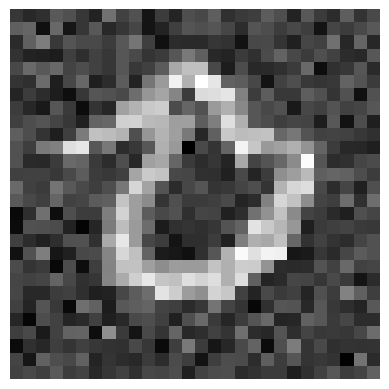

Number 'one'


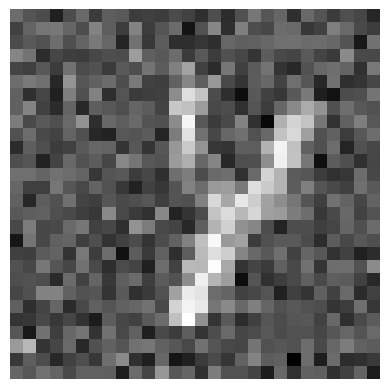

Number 'two'


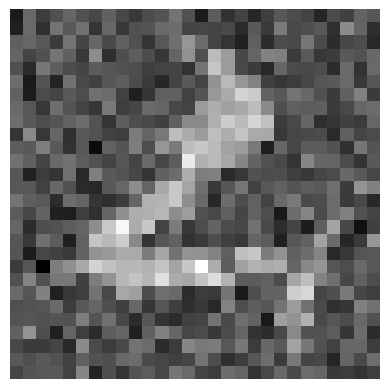

Number 'three'


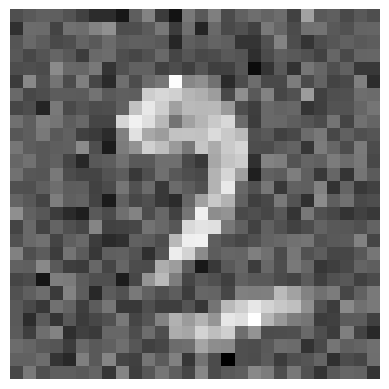

Number 'four'


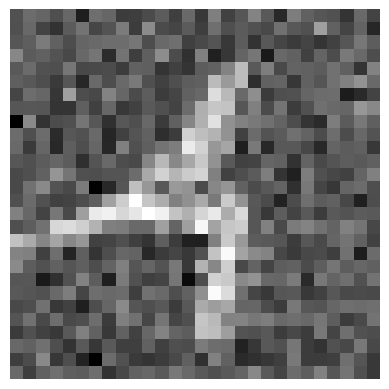

Number 'five'


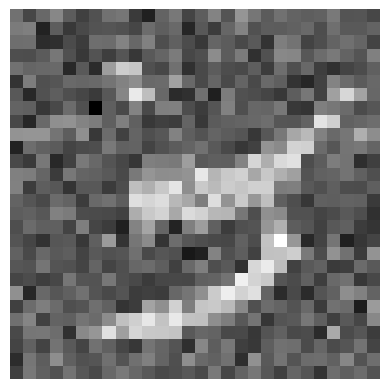

Number 'six'


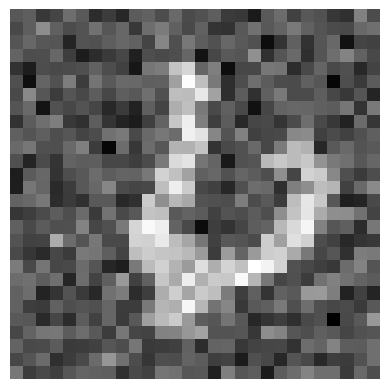

Number 'seven'


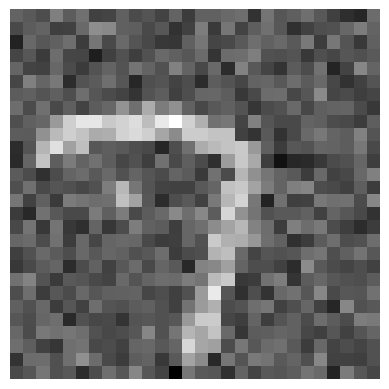

Number 'eight'


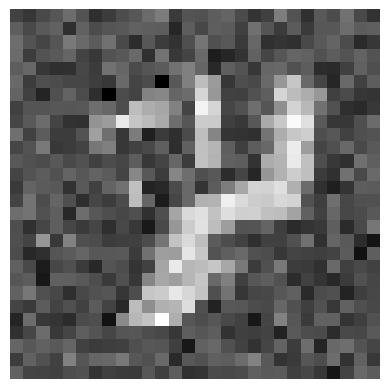

Number 'nine'


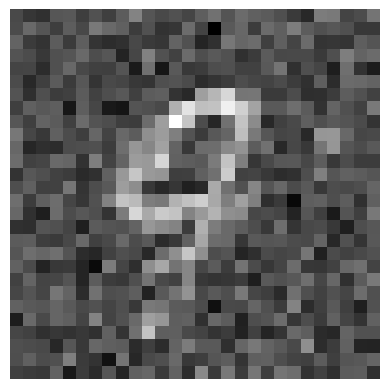

Number 'ten'


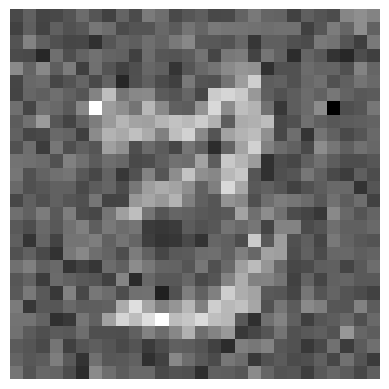

In [13]:
# Run testing DDIM
test_numbers = [0,1,2,3,4,5,6,7,8,9,10]
with torch.no_grad():
  sampled_imgs = sampling_imgs(test_numbers, mode="ddim")

# Visualize testing results
for idx in range(len(test_numbers)):
  print("Number '%s'" % n2t_mapping[test_numbers[idx]])

  max_v = np.max(sampled_imgs[idx][0])
  min_v = np.min(sampled_imgs[idx][0])
  img = (sampled_imgs[idx][0] - min_v) / (max_v - min_v)
  show_img(img)

100%|██████████| 300/300 [00:04<00:00, 69.37it/s]


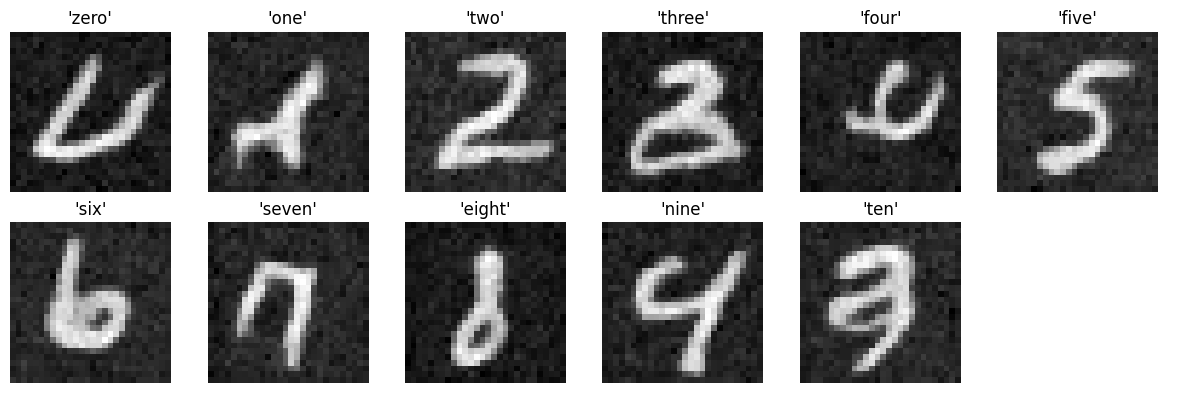

In [14]:
# Run testing DDPM
test_numbers = [0,1,2,3,4,5,6,7,8,9,10]
with torch.no_grad():
  sampled_imgs = sampling_imgs(test_numbers, mode="ddpm")

# Visualize testing results
# for idx in range(len(test_numbers)):
#   print("Number '%s'" % n2t_mapping[test_numbers[idx]])

#   max_v = np.max(sampled_imgs[idx][0])
#   min_v = np.min(sampled_imgs[idx][0])
#   img = (sampled_imgs[idx][0] - min_v) / (max_v - min_v)
#   show_img(img)
fig, axes = plt.subplots(2, 6, figsize=(12, 4))
axes = axes.flatten()

for idx in range(len(test_numbers)):
    max_v = np.max(sampled_imgs[idx][0])
    min_v = np.min(sampled_imgs[idx][0])
    img = (sampled_imgs[idx][0] - min_v) / (max_v - min_v)
    
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(f"'{n2t_mapping[test_numbers[idx]]}'")
    axes[idx].axis('off')

# Hide the last subplot (11 images, 12 subplots)
axes[-1].axis('off')
plt.tight_layout()
plt.show()

100%|██████████| 300/300 [00:04<00:00, 69.08it/s]




Number: ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']
Step: 300


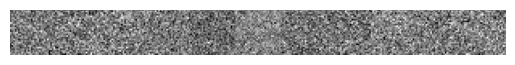

Step: 250


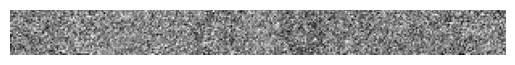

Step: 200


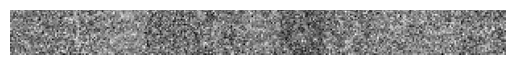

Step: 150


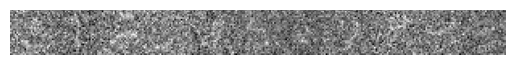

Step: 100


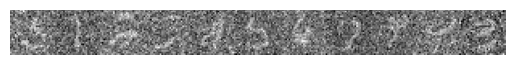

Step: 50


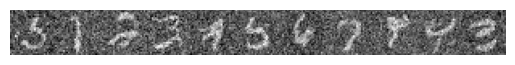

Step: 0


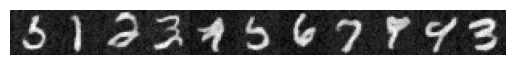

In [15]:
test_numbers = [0,1,2,3,4,5,6,7,8,9,10]
steps = list(range(T, -1, -50))

with torch.no_grad():
  reverse_steps = sampling_imgs(test_numbers, return_steps=steps)

print("\n=========================\n")
print("Number:", [n2t_mapping[x] for x in test_numbers])

for sidx, step in enumerate(steps):
  print("Step:", step)
  step_img = []

  for idx in range(len(test_numbers)):
    # print("Number '%s'" % n2t_mapping[test_numbers[idx]])

    max_v = np.max(reverse_steps[sidx][idx][0])
    min_v = np.min(reverse_steps[sidx][idx][0])
    img = (reverse_steps[sidx][idx][0] - min_v) / (max_v - min_v)
    step_img.append(img)

  step_img = np.concatenate(step_img, axis=-1)
  show_img(step_img)

In [16]:
!cp contextual_model.pt "/content/drive/MyDrive/Colab Notebooks/Diffusion/contextual_model.pt"
!cp beta_t.pkl "/content/drive/MyDrive/Colab Notebooks/Diffusion/beta_t.pkl"

cp: cannot create regular file '/content/drive/MyDrive/Colab Notebooks/Diffusion/contextual_model.pt': No such file or directory


cp: cannot create regular file '/content/drive/MyDrive/Colab Notebooks/Diffusion/beta_t.pkl': No such file or directory
